## Vanilla Classification on Full Dataset
This notebook contains first vanilla run of several classification models on the full dataset. 

In [1]:
# import libraries
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
import gzip

from yellowbrick.classifier import ConfusionMatrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

C:\Program Files\Python36\Lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Data Preprocessing

In [2]:
# import data and convert to pandas dataframe
dataset = pd.read_parquet('../Data/newdata_v2.parquet', engine = 'pyarrow')

In [3]:
# check if read correctly
dataset.head()

,lat,lon,MaxFRP,Uncertainty,QA,gaugeQualityInfo,hourlyPrecipRate,hourlyPrecipRateGC,observationTimeFlag,satelliteInfoFlag,...,SoilTMP0_10cm_inst,SoilMoi0_10cm_inst,SoilTMP100_200cm_inst,SoilTMP10_40cm_inst,SoilTMP40_100cm_inst,Swnet_tavg,Tair_f_inst,Tveg_tavg,Wind_f_inst,label
0,42.059122,-125.292524,0.0,0.0,0.0,0.0,0.0,0.174706,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,water
1,42.059122,-125.288031,0.0,0.0,0.0,0.0,0.0,0.174706,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,water
2,42.059122,-125.283538,0.0,0.0,0.0,0.0,0.0,0.174706,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,water
3,42.059122,-125.279044,0.0,0.0,0.0,0.0,0.0,0.174706,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,water
4,42.059122,-125.274551,0.0,0.0,0.0,0.0,0.0,0.174706,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,water


In [4]:
# check class imbalance
dataset['label'].value_counts()

land           3740525
water          1725997
burned           11330
fwi_high          9838
cloud              397
active_fire         53
Name: label, dtype: int64

In [5]:
# Split data into X and y
# Need to save coordinates AFTER train test split in order to merge at end

X = dataset.drop('label', axis = 1)
y = dataset['label']

# Predicting categories: ['water', 'burned', 'fwi_high', 'land', 'fwi_moderate', 'active_fire']

In [6]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify = y)

In [7]:
# Save coordinates
train_coords = X_train.loc[:,['lat', 'lon']]
test_coords = X_test.loc[:,['lat', 'lon']]

# Drop coordinates from dataset
X_train.drop(['lat','lon'], axis = 1, inplace = True)
X_test.drop(['lat','lon'], axis = 1, inplace = True)

C:\Program Files\Python36\Lib\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Scaling Data**

In [8]:
# Scale Data
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

# Binarizing is part of OneVsRestClassifier implementation

**Balancing Classes: Oversampling Methods**

In [9]:
# Random Over Sampler
ros = RandomOverSampler(random_state=1)
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

In [ ]:
# Smote
sm = SMOTE(random_state=1)
x_smote, y_smote = sm.fit_resample(x_train, y_train)

### Models
1. <a href=#log>Logistic Regression</a>

<a id=log></a>
### Multiclass Logisitic Regression

In [10]:
lr = LogisticRegression(penalty = 'l1', solver = 'saga', n_jobs = -1, verbose=1, max_iter=10)

In [11]:
trained_model = lr.fit(x_resampled, y_resampled)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 474 seconds


C:\Program Files\Python36\Lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.2min finished


In [12]:
trained_model

LogisticRegression(max_iter=10, n_jobs=-1, penalty='l1', solver='saga',
                   verbose=1)

In [13]:
# Save trained model
dump(trained_model, 'lg_newv2_oversamp.joblib')

['lg_newv2_oversamp.joblib']

In [14]:
y_pred_train = trained_model.predict(x_train)

In [15]:
# Metrics
balanced_accuracy_score(y_train, y_pred_train)

0.7983594693071504

In [16]:
y_pred_test = trained_model.predict(x_test)
balanced_accuracy_score(y_test, y_pred_test)

0.791016444942212

C:\Program Files\Python36\Lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Program Files\Python36\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


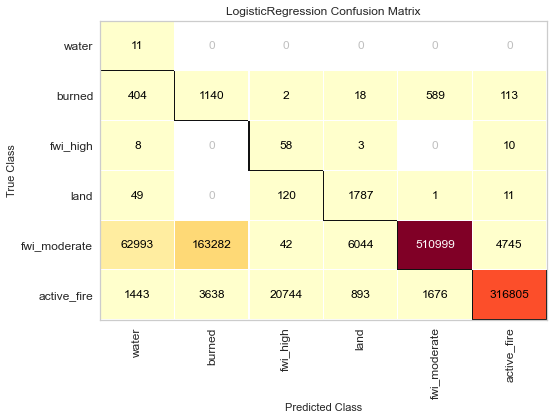

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [17]:
cm_train = ConfusionMatrix(trained_model, classes =['water', 'burned', 'fwi_high', 'land', 'fwi_moderate', 'active_fire'])
cm_train.score(x_test, y_test)
cm_train.show()

## Random Forest

In [19]:
rc = RandomForestClassifier(n_estimators = 50, max_depth = 10, min_samples_split = 1000, n_jobs = -1, verbose=1)

In [20]:
trained_model = rc.fit(x_resampled, y_resampled)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.3min finished


In [21]:
trained_model

RandomForestClassifier(max_depth=10, min_samples_split=1000, n_estimators=50,
                       n_jobs=-1, verbose=1)

In [22]:
# Save trained model
dump(trained_model, 'rc_newv2_oversamp.joblib')

['rc_newv2_oversamp.joblib']

In [23]:
trained_model = load('rc_newv2_oversamp.joblib')

In [24]:
features = ['MaxFRP', 'EVI', 'EVI2', 'NVDI', 'NIR_reflectance',
       'SWIR1_reflectance', 'SWIR2_reflectance', 'SWIR3_reflectance',
       'VI_Quality', 'blue_reflectance', 'composite_day_of_the_year',
       'green_reflectance', 'pixel_reliability', 'red_reflectance',
       'relative_azimuth_angle', 'sun_zenith_angle', 'view_zenith_angle',
       'gaugeQualityInfo', 'hourlyPrecipRate', 'hourlyPrecipRateGC',
       'observationTimeFlag', 'satelliteInfoFlag', 'Albedo_inst',
       'AvgSurfT_inst', 'CanopInt_inst', 'ECanop_tavg', 'ESoil_tavg',
       'Evap_tavg', 'LWdown_f_tavg', 'Lwnet_tavg', 'PotEvap_tavg',
       'Psurf_f_inst', 'Qair_f_inst', 'Qg_tavg', 'Qh_tavg', 'Qle_tavg',
       'Qs_acc', 'Qsb_acc', 'Qsm_acc', 'Rainf_f_tavg', 'RootMoist_inst',
       'SWE_inst', 'SWdown_f_tavg', 'SnowDepth_inst', 'Snowf_tavg',
       'SoilMoi100_200cm_inst', 'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst',
       'SoilTMP0_10cm_inst', 'SoilMoi0_10cm_inst', 'SoilTMP100_200cm_inst',
       'SoilTMP10_40cm_inst', 'SoilTMP40_100cm_inst', 'Swnet_tavg',
       'Tair_f_inst', 'Tveg_tavg', 'Wind_f_inst', 'Uncertainty', 'QA']

In [25]:
feat_percent = []
for value in trained_model.feature_importances_:
    feat_percent.append(value*100)

In [26]:
feature_selection = pd.DataFrame(zip(features, feat_percent))

In [27]:
feature_selection.sort_values(by = 1, ascending = False)

,0,1
2,EVI2,21.764456
4,NIR_reflectance,11.621186
3,NVDI,6.846198
5,SWIR1_reflectance,5.726832
15,sun_zenith_angle,5.078505
8,VI_Quality,5.033150
7,SWIR3_reflectance,4.813216
19,hourlyPrecipRateGC,4.232663
32,Qair_f_inst,3.952831
28,LWdown_f_tavg,3.168176


In [28]:
list(feature_selection.loc[feature_selection[1] < 1, 0])

['MaxFRP',
 'EVI',
 'SWIR2_reflectance',
 'blue_reflectance',
 'composite_day_of_the_year',
 'green_reflectance',
 'red_reflectance',
 'gaugeQualityInfo',
 'hourlyPrecipRate',
 'Albedo_inst',
 'AvgSurfT_inst',
 'CanopInt_inst',
 'ECanop_tavg',
 'Evap_tavg',
 'Lwnet_tavg',
 'PotEvap_tavg',
 'Qs_acc',
 'Qsb_acc',
 'Qsm_acc',
 'RootMoist_inst']

In [29]:
y_pred_train = trained_model.predict(x_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    5.5s finished


In [30]:
# Metrics
balanced_accuracy_score(y_train, y_pred_train)

0.9267857676893035

In [31]:
y_pred_test = trained_model.predict(x_test)
balanced_accuracy_score(y_test, y_pred_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    1.3s finished


0.9234337231673032

C:\Program Files\Python36\Lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Program Files\Python36\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    1.3s finished


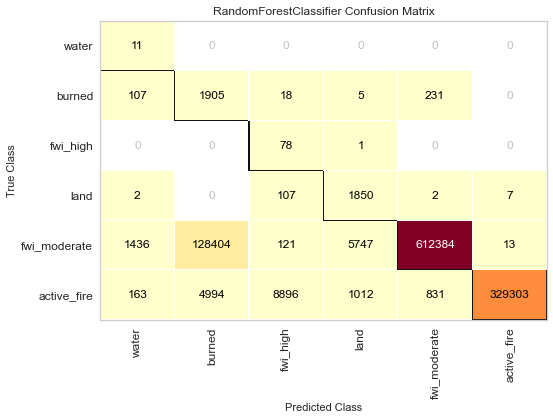

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [32]:
cm_train = ConfusionMatrix(trained_model, classes =['water', 'burned', 'fwi_high', 'land', 'fwi_moderate', 'active_fire'])
cm_train.score(x_test, y_test)
cm_train.show()

### Create Output of Predictions on All Data for Mapping

In [54]:
import numpy as np
import pandas as pd

prediction = pd.DataFrame(y_pred_test, columns=['predictions']).to_csv('prediction_test.csv')

In [58]:
len(y_pred_test)

1097628

In [57]:
y

0          water
1          water
2          water
3          water
4          water
           ...  
5488135     land
5488136     land
5488137     land
5488138     land
5488139     land
Name: label, Length: 5488140, dtype: object

In [60]:
import pandas
import geopandas

from io import StringIO

file = pd.read_parquet('../Data/newdata_v2.parquet', engine = 'pyarrow')
file = file.loc[:,['lat', 'lon', 'label']]
file=test_coords.loc[:,['lat', 'lon']]

gdf = geopandas.GeoDataFrame(pandas.read_csv('prediction_test.csv'),geometry=geopandas.points_from_xy(file.lon, file.lat))
gdf.to_file('prediction_test.shp')

In [62]:
import geopandas
myshpfile = geopandas.read_file('prediction_test.shp')
myshpfile.to_file('myJson.geojson', driver='GeoJSON')